# Supervised learning

In [524]:
import sys

assert sys.version_info >= (3, 7)
import pandas as pd

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [525]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import dataset and explore it

In [526]:
import openml
import pandas as pd

# Get Dataset from OPENML
dataset = openml.datasets.get_dataset(23)


df, *_ = dataset.get_data()

# Get features as X
X = df.drop('Contraceptive_method_used',axis=1)


# Get class as y
y = df['Contraceptive_method_used']


In [527]:
X

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0
...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0
1469,33,4,4,3,1,1,1,4,0
1470,39,3,3,8,1,0,1,4,0
1471,33,3,3,4,1,0,2,2,0


In [528]:
y.value_counts()

Contraceptive_method_used
1    629
3    511
2    333
Name: count, dtype: int64

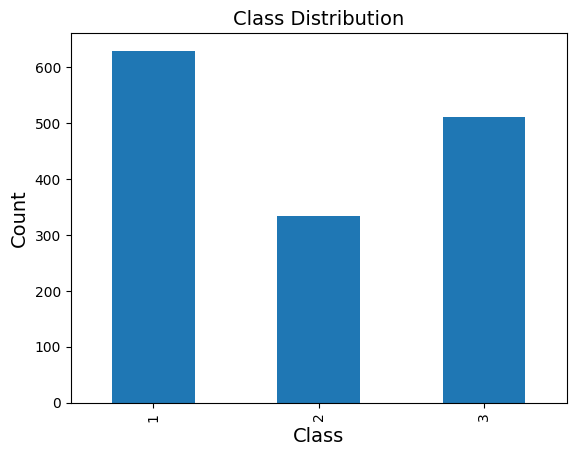

In [529]:
import matplotlib.pyplot as plt

y.value_counts().sort_index().plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.show()

In [530]:
X.head()

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Husbands_occupation,Standard-of-living_index,Media_exposure
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0


In [531]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Wifes_age                     1473 non-null   uint8   
 1   Wifes_education               1473 non-null   category
 2   Husbands_education            1473 non-null   category
 3   Number_of_children_ever_born  1473 non-null   uint8   
 4   Wifes_religion                1473 non-null   category
 5   Wifes_now_working%3F          1473 non-null   category
 6   Husbands_occupation           1473 non-null   category
 7   Standard-of-living_index      1473 non-null   category
 8   Media_exposure                1473 non-null   category
dtypes: category(7), uint8(2)
memory usage: 14.2 KB


# Description of Dataset
The dataset is focused in predicting contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics. The samples come from a subset of the 1987 National Indonesia Contraceptive Prevalence Survey and they contain married women who were either not pregnant or do not know if they were at the time of interview.

It has 1473 instances with 10 features including the class. Information of the features:

* Wife's age (16-49): numerical
* Wife's education (categorical) 1=low, 2, 3, 4=high
* Husband's education (categorical) 1=low, 2, 3, 4=high
* Number of children ever born (0-16): numerical
* Wife's religion (binary) 0=Non-Islam, 1=Islam
* Wife's now working? (binary) 0=Yes, 1=No
* Husband's occupation (categorical) 1, 2, 3, 4
* Standard-of-living index (categorical) 1=low, 2, 3, 4=high
* Media exposure (binary) 0=Good, 1=Not good
* Contraceptive method used (class attribute) 1=No-use 2=Long-term 3=Short-term

(OpenMl, n.d.)

In this case, the categorical features are set as nominal, but if we observe there are some that may seem as ordinal because they use a low to high scale. For that reason, one of the aims is to treat those features as ordinal and the other is to treat it as nominal. After doing this, the performance will be evaluated to assess which option is the best. There are also no Nan values in the dataset.

As we can see above the classes are a bit unbalanced, because class 1 is 42.7% of the dataset, while class 2 is 34.69% and class 3 is 22.60%. So even if they don't have the same number of samples, they are still close to each other.

In [532]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert nominal to ordinal
We will use get_dummies for this because it allows us to separate the variables in a way in which we don't give more weight to a value.

In [533]:
#Avoid modifying train set

X_train_c = X_train.copy()
X_test_c = X_test.copy()


#Use dummies
categorical_features = ['Husbands_occupation']
X_train_enc = pd.get_dummies(X_train_c, columns=categorical_features, drop_first=True)
X_test_enc = pd.get_dummies(X_test_c, columns=categorical_features, drop_first=True)


X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

X_test_enc

,Wifes_age,Wifes_education,Husbands_education,Number_of_children_ever_born,Wifes_religion,Wifes_now_working%3F,Standard-of-living_index,Media_exposure,Husbands_occupation_2,Husbands_occupation_3,Husbands_occupation_4
852,29,3,3,4,1,1,4,0,False,True,False
184,35,3,4,5,1,0,2,0,True,False,False
1261,23,4,4,1,0,1,4,0,False,False,False
67,30,2,3,3,1,1,1,0,False,True,False
220,22,2,3,1,1,1,3,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
560,38,4,4,3,1,0,4,0,False,False,False
946,25,2,2,1,1,1,3,0,False,True,False
522,25,3,1,4,1,1,1,0,False,True,False
874,24,4,3,3,1,1,3,0,False,True,False


# Default Decision Tree

In [534]:
from sklearn.tree import DecisionTreeClassifier

default_tree = DecisionTreeClassifier(random_state=42)
default_tree.fit(X_train_enc, y_train)

DecisionTreeClassifier(random_state=42)

In [535]:
from sklearn.metrics import classification_report

y_pred_default = default_tree.predict(X_test_enc)
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           1       0.64      0.62      0.63       130
           2       0.41      0.39      0.40        71
           3       0.40      0.43      0.41        94

    accuracy                           0.51       295
   macro avg       0.48      0.48      0.48       295
weighted avg       0.51      0.51      0.51       295



In [536]:
params = default_tree.get_params()
print(f"Criterion: {params['criterion']}")
print(f"Max depth: {params['max_depth']}")
print(f"Min samples split: {params['min_samples_split']}")

Criterion: gini
Max depth: None
Min samples split: 2


# Now let's do dummies for the other categorical variables

In [537]:
X_train_c2 = X_train.copy()
X_test_c2 = X_test.copy()



#Use dummies
categorical_features = ["Wifes_education",'Husbands_occupation',"Husbands_education","Standard-of-living_index" ]
X_train_enc2 = pd.get_dummies(X_train_c2, columns=categorical_features, drop_first=True)
X_test_enc2 = pd.get_dummies(X_test_c2, columns=categorical_features, drop_first=True)



X_test_enc2 = X_test_enc2.reindex(columns=X_train_enc2.columns, fill_value=0)



In [538]:
from sklearn.tree import DecisionTreeClassifier

default_tree = DecisionTreeClassifier(random_state=42)
default_tree.fit(X_train_enc2, y_train)

DecisionTreeClassifier(random_state=42)

In [539]:
from sklearn.metrics import classification_report

y_pred_default = default_tree.predict(X_test_enc2)
print(classification_report(y_test, y_pred_default))

              precision    recall  f1-score   support

           1       0.62      0.65      0.64       130
           2       0.40      0.38      0.39        71
           3       0.45      0.44      0.44        94

    accuracy                           0.52       295
   macro avg       0.49      0.49      0.49       295
weighted avg       0.51      0.52      0.52       295



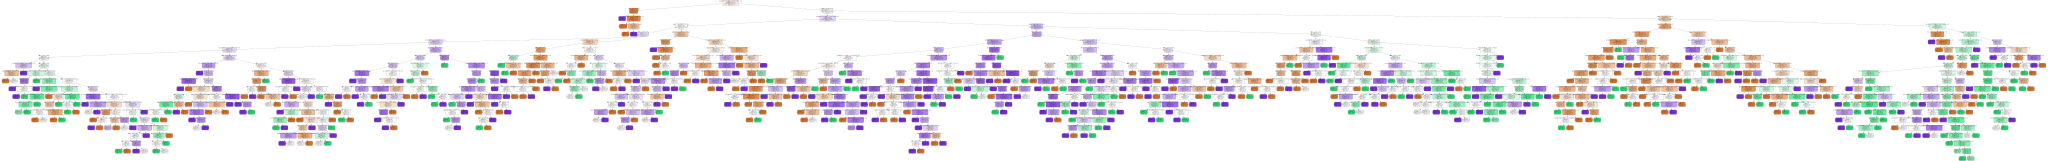

In [540]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    default_tree,
    out_file="default_tree.dot",
    feature_names=X_train_enc2.columns,
    class_names=[ "1", '2', '3'],
    rounded=True,
    filled=True
)

Source.from_file("default_tree.dot")

Therefore, the results with multiple dummies for the features have better results. So as the web page in OpenML says, we'll treat them as nominal and convert with dummies. Once we've decided this, we can restart the process to create a fine-tuned decision tree.

In [541]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}


# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_weighted',  
    cv=10,
)

grid_search.fit(X_train_enc2, y_train)

best_tree = grid_search.best_estimator_


y_pred_default = best_tree.predict(X_test_enc2)
print(classification_report(y_test, y_pred_default))


print("Best parameters:", grid_search.best_params_)
print("Best weighted F1 score:", grid_search.best_score_)


              precision    recall  f1-score   support

           1       0.73      0.54      0.62       130
           2       0.56      0.42      0.48        71
           3       0.44      0.68      0.54        94

    accuracy                           0.56       295
   macro avg       0.58      0.55      0.55       295
weighted avg       0.60      0.56      0.56       295

Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best weighted F1 score: 0.5347390332562895
